# BMW Stock Price Prediction Using XGBoost, LSTM, and Deep Reinforcement Learning

In [59]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from xgboost import XGBRegressor, XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import gym
from stable_baselines3 import A2C, DDPG

# Data preprocessing

In [2]:
bmw = pd.read_csv('BMW_Data.csv',parse_dates=['Date'])
#bmw.columns
bmw.head()

,Date,Adj_Close,Close,High,Low,Open,Volume
0,1996-11-08,8.100290,18.171000,18.209999,18.171000,18.209999,767000
1,1996-11-11,8.078445,18.122000,18.200001,18.082001,18.190001,260000
2,1996-11-12,8.139520,18.259001,18.327999,18.091999,18.160999,1066000
3,1996-11-13,8.126592,18.230000,18.344000,18.190001,18.344000,793000
4,1996-11-14,8.152893,18.289000,18.289000,18.132000,18.205000,351000


## Missing values:

In [3]:
missing_values = bmw.isnull().sum()
missing_values

Date         0
Adj_Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64

In [4]:
bmw.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,7212,2010-11-05 03:40:13.976705536,1996-11-08 00:00:00,2003-10-07 18:00:00,2010-10-19 12:00:00,2017-11-22 06:00:00,2024-12-30 00:00:00,NaN
Adj_Close,7212.0,36.020199,8.065074,16.443254,26.329212,53.329208,108.059044,23.641099
Close,7212.0,56.427535,17.040001,34.4575,49.372501,79.3325,122.599998,25.245886
High,7212.0,57.111143,17.815001,34.900002,50.094999,80.105,123.75,25.415148
Low,7212.0,55.720695,16.0,33.8875,48.752501,78.342497,120.349998,25.055661
Open,7212.0,56.446728,17.280001,34.465001,49.2675,79.379997,123.300003,25.252263
Volume,7212.0,2107945.625347,0.0,1194307.75,1793777.5,2636572.25,28719542.0,1467180.482558


### Shape:

In [5]:
bmw.shape

(7212, 7)

## Moving Averages :

$$MA_{n}(t) = \frac{1}{n} \sum_{i = t-(n-1)}^{t}$$

$MA_{50}(t) = \frac{1}{50} \sum_{i = t-49}^{t}$ - 50-day moving average of the Close column 

$MA_{200}(t) = \frac{1}{200} \sum_{i=t-199}^{t}$ - 200-day moving average of the Close column  

Where $MA_{n}(t)$ is the moving average at time $t$, using the last $n$ closing prices.

In [6]:
bmw['MA_50'] = bmw['Close'].rolling(window = 50).mean()
bmw['MA_200'] = bmw['Close'].rolling(window = 200).mean()
bmw.head()

,Date,Adj_Close,Close,High,Low,Open,Volume,MA_50,MA_200
0,1996-11-08,8.100290,18.171000,18.209999,18.171000,18.209999,767000,NaN,NaN
1,1996-11-11,8.078445,18.122000,18.200001,18.082001,18.190001,260000,NaN,NaN
2,1996-11-12,8.139520,18.259001,18.327999,18.091999,18.160999,1066000,NaN,NaN
3,1996-11-13,8.126592,18.230000,18.344000,18.190001,18.344000,793000,NaN,NaN
4,1996-11-14,8.152893,18.289000,18.289000,18.132000,18.205000,351000,NaN,NaN


In [7]:
print(bmw.isnull().sum())

Date           0
Adj_Close      0
Close          0
High           0
Low            0
Open           0
Volume         0
MA_50         49
MA_200       199
dtype: int64


In [8]:
bmw.dropna(inplace = True)
bmw.shape

(7013, 9)

In [9]:
bmw.head()

,Date,Adj_Close,Close,High,Low,Open,Volume,MA_50,MA_200
199,1997-08-14,11.720482,26.292000,27.531,26.271999,27.531000,660400,28.45700,24.673890
200,1997-08-15,11.387482,25.545000,26.351,25.407000,26.351000,834600,28.40764,24.710760
201,1997-08-18,11.400411,25.573999,25.938,24.580999,25.171000,1398800,28.37362,24.748020
202,1997-08-19,11.834599,26.548000,26.548,25.486000,25.750999,634400,28.36458,24.789465
203,1997-08-20,11.970564,26.853001,27.138,26.823000,26.912001,166400,28.36164,24.832580


### MinMaxScalling:

$$X_{\text{scaled}} = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}}$$
where:
- $X_{\text{scaled}}$ is the scaled value.

- $X$ is the original value.

- $X_{\text{min}}$ is the minimum value of the feature in the dataset.

- $X_{\text{max}}$ is the maximum value of the feature in the dataset.

In [10]:
scaler = MinMaxScaler()
bmw[['Adj_Close','Close','High','Low','Open','Volume','MA_50','MA_200']] = scaler.fit_transform(
    bmw[['Adj_Close','Close','High','Low','Open','Volume','MA_50','MA_200']])

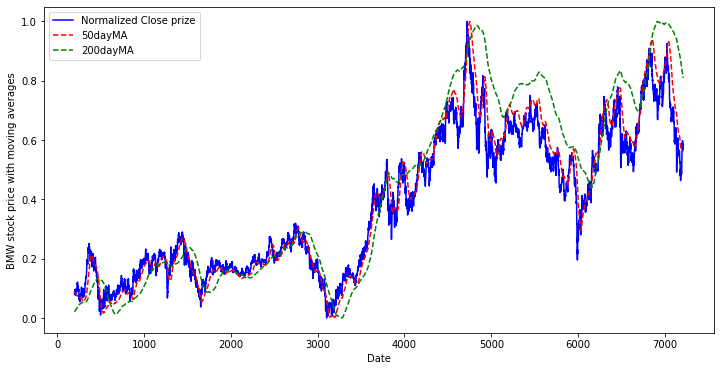

In [11]:
plt.figure(figsize = (12,6))
plt.plot(bmw.index,bmw['Close'], label = "Normalized Close prize", color = 'blue')
plt.plot(bmw.index, bmw['MA_50'], label = "50dayMA", color = 'red', linestyle = 'dashed')
plt.plot(bmw.index, bmw['MA_200'], label = "200dayMA", color = 'green', linestyle = 'dashed')
plt.xlabel('Date')
plt.ylabel('BMW stock price with moving averages')
plt.legend()
plt.show()

### Relative Strength Index (RSI)

$$RSI = 100 - \frac{100}{1 + RS}$$
where : $RS = \frac{\text{Average Gain}}{\text{Average Loss}}$

$\Delta P_t = P_t - P_{t-1}$

$\text{Gain}_t = \begin{cases} \Delta P_t & \text{if } \Delta P_t > 0 \\0 & \text{otherwise}\end{cases}$

$\text{Loss}_t = \begin{cases} -\Delta P_t & \text{if } \Delta P_t < 0 \\0 & \text{otherwise}\end{cases}$

$\text{Average Gain} = \frac{\sum_{t=1}^{n} \text{Gain}_t}{n}$

$\text{Average Loss} = \frac{\sum_{t=1}^{n} \text{Loss}_t}{n}$

In [12]:
def calculate_rsi(data, window = 14):
    delta = data.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window = window).mean()
    loss = (-delta.where(delta <0, 0)).rolling(window = window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

bmw['RSI'] = calculate_rsi(bmw['Close'])

### MACD (Moving Average Convergence Divergence)

$EMA_t = P_t \times \frac{2}{N+1} + EMA_{t-1} \times \left(1 - \frac{2}{N+1}\right)$

$EMA_{12} = \text{EMA with span } 12$

$EMA_{26} = \text{EMA with span } 26$

$MACD_t = EMA_{12,t} - EMA_{26,t}$

$\text{Signal Line}_t = \text{EMA of } MACD_t \text{ with span } 9$

$\text{MACD Histogram}_t = MACD_t - \text{Signal Line}_t$

In [13]:
bmw['EMA_12'] = bmw['Close'].ewm(span = 12, adjust = False).mean()
bmw['EMA_26'] = bmw['Close'].ewm(span = 26, adjust = False).mean()
bmw['MACD'] = bmw['EMA_12'] - bmw['EMA_26']
bmw['MACD_Signal'] = bmw['MACD'].ewm(span = 9, adjust = False).mean()
bmw['MACD_Hist'] = bmw['MACD'] - bmw['MACD_Signal']

### Bollinger Bands

$SMA_t = \frac{1}{N} \sum_{i=t-N+1}^{t} P_i$

$\sigma_t = \sqrt{\frac{1}{N} \sum_{i=t-N+1}^{t} (P_i - SMA_t)^2}$

$\text{Upper}_t = SMA_t + (2 \times \sigma_t)$

$\text{Lower}_t = SMA_t - (2 \times \sigma_t)$

In [14]:
bmw['Rolling_Mean'] = bmw['Close'].rolling(window = 20).mean()
bmw['Rolling_Std'] = bmw['Close'].rolling(window = 20).std()
bmw['Upper_BB'] = bmw['Rolling_Mean'] + (bmw['Rolling_Std'] * 2)
bmw['Lower_BB'] = bmw['Rolling_Mean'] - (bmw['Rolling_Std'] * 2)

In [15]:
bmw.head()

,Date,Adj_Close,Close,High,Low,Open,Volume,MA_50,MA_200,RSI,EMA_12,EMA_26,MACD,MACD_Signal,MACD_Hist,Rolling_Mean,Rolling_Std,Upper_BB,Lower_BB
199,1997-08-14,0.036556,0.087647,0.091717,0.098438,0.096689,0.022995,0.087290,0.021159,NaN,0.087647,0.087647,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
200,1997-08-15,0.033226,0.080570,0.080578,0.090149,0.085559,0.029060,0.086762,0.021632,NaN,0.086558,0.087123,-0.000565,-0.000113,-0.000452,NaN,NaN,NaN,NaN
201,1997-08-18,0.033355,0.080845,0.076679,0.082233,0.074429,0.048706,0.086399,0.022111,NaN,0.085679,0.086658,-0.000978,-0.000286,-0.000692,NaN,NaN,NaN,NaN
202,1997-08-19,0.037698,0.090072,0.082437,0.090906,0.079900,0.022089,0.086303,0.022643,NaN,0.086355,0.086911,-0.000556,-0.000340,-0.000216,NaN,NaN,NaN,NaN
203,1997-08-20,0.039057,0.092961,0.088007,0.103718,0.090851,0.005794,0.086271,0.023197,NaN,0.087371,0.087359,0.000013,-0.000269,0.000282,NaN,NaN,NaN,NaN


In [16]:
print(bmw.isnull().sum())

Date             0
Adj_Close        0
Close            0
High             0
Low              0
Open             0
Volume           0
MA_50            0
MA_200           0
RSI             13
EMA_12           0
EMA_26           0
MACD             0
MACD_Signal      0
MACD_Hist        0
Rolling_Mean    19
Rolling_Std     19
Upper_BB        19
Lower_BB        19
dtype: int64


In [17]:
bmw.dropna(inplace = True)
bmw.shape

(6994, 19)

In [18]:
bmw.head()

,Date,Adj_Close,Close,High,Low,Open,Volume,MA_50,MA_200,RSI,EMA_12,EMA_26,MACD,MACD_Signal,MACD_Hist,Rolling_Mean,Rolling_Std,Upper_BB,Lower_BB
218,1997-09-10,0.038616,0.092023,0.090046,0.100134,0.092794,0.177621,0.080366,0.029873,46.132860,0.086933,0.086548,0.000384,-0.000532,0.000916,0.086018,0.005669,0.097357,0.074680
219,1997-09-11,0.036730,0.088016,0.080578,0.096464,0.084635,0.117056,0.079742,0.030238,48.828121,0.087099,0.086657,0.000442,-0.000337,0.000780,0.086037,0.005675,0.097388,0.074686
220,1997-09-12,0.033752,0.081688,0.083268,0.092036,0.084814,0.161688,0.079049,0.030584,44.115389,0.086267,0.086289,-0.000022,-0.000274,0.000252,0.086093,0.005624,0.097341,0.074845
221,1997-09-15,0.038750,0.092308,0.084665,0.093733,0.083522,0.128825,0.078567,0.030961,58.998965,0.087196,0.086735,0.000461,-0.000127,0.000588,0.086666,0.005645,0.097956,0.075376
222,1997-09-16,0.042080,0.099384,0.091717,0.100134,0.089823,0.135796,0.078147,0.031376,61.564010,0.089071,0.087672,0.001399,0.000178,0.001221,0.087131,0.006288,0.099708,0.074555


In [19]:
scaler2 = MinMaxScaler()
bmw[['RSI','MACD','MACD_Signal','MACD_Hist','Upper_BB','Lower_BB']] = scaler2.fit_transform(
    bmw[['RSI', 'MACD','MACD_Signal','MACD_Hist','Upper_BB', 'Lower_BB']])

In [20]:
print(bmw.columns)

Index(['Date', 'Adj_Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'MA_50',
       'MA_200', 'RSI', 'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'MACD_Hist',
       'Rolling_Mean', 'Rolling_Std', 'Upper_BB', 'Lower_BB'],
      dtype='object')


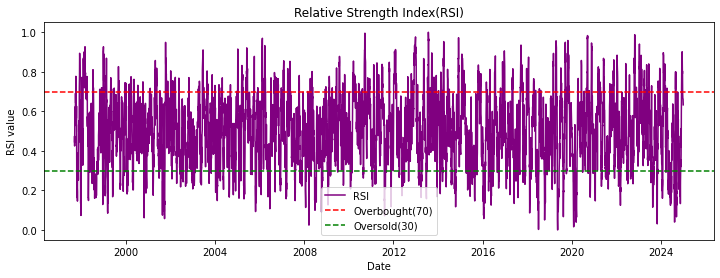

In [21]:
bmw.set_index('Date',inplace = True)
plt.figure(figsize = (12,4))
plt.plot(bmw.index, bmw['RSI'], label = "RSI", color = 'purple')
plt.axhline(y = 0.7, color = 'red', linestyle = 'dashed', label = "Overbought(70)")
plt.axhline(y = 0.3, color = 'green', linestyle = 'dashed', label = "Oversold(30)")
plt.xlabel("Date")
plt.ylabel("RSI value")
plt.title("Relative Strength Index(RSI)")
plt.legend()
plt.show()

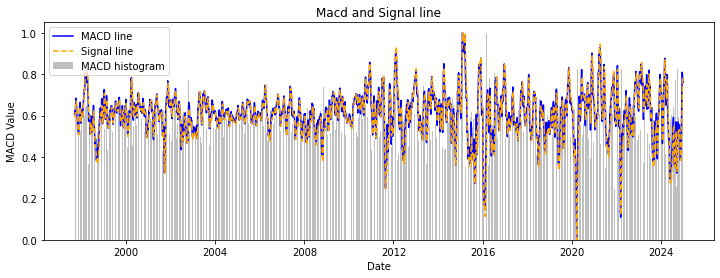

In [22]:
plt.figure(figsize = (12,4))
plt.plot(bmw.index, bmw['MACD'], label = "MACD line", color = 'blue')
plt.plot(bmw.index, bmw['MACD_Signal'], label = "Signal line", color = 'orange', linestyle = 'dashed')
plt.bar(bmw.index, bmw['MACD_Hist'], label = "MACD histogram", color = 'gray', alpha = 0.5)
plt.xlabel("Date")
plt.ylabel("MACD Value")
plt.title("Macd and Signal line")
plt.legend()
plt.show()

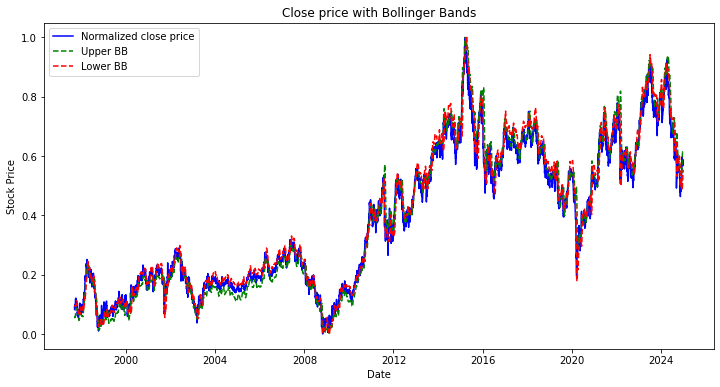

In [23]:
plt.figure(figsize = (12,6))
plt.plot(bmw.index, bmw['Close'], label = "Normalized close price", color = 'blue')
plt.plot(bmw.index, bmw['Upper_BB'], label = "Upper BB", color = 'green', linestyle = 'dashed')
plt.plot(bmw.index, bmw['Lower_BB'], label = "Lower BB", color = 'red', linestyle = 'dashed')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Close price with Bollinger Bands")
plt.legend()
plt.show()

In [37]:
features = bmw[['RSI','MACD','MACD_Signal','MACD_Hist','Upper_BB','Lower_BB','Open','High','Low','Volume']]

bmw['target_r'] = bmw['Close'].shift(-1)
bmw['target_cl'] = (bmw['Close'].shift(-1) > bmw['Close']).astype(int)

In [33]:
print(bmw.isnull().sum())

Adj_Close       0
Close           0
High            0
Low             0
Open            0
Volume          0
MA_50           0
MA_200          0
RSI             0
EMA_12          0
EMA_26          0
MACD            0
MACD_Signal     0
MACD_Hist       0
Rolling_Mean    0
Rolling_Std     0
Upper_BB        0
Lower_BB        0
target_r        1
target_cl       0
dtype: int64


In [34]:
bmw.dropna(inplace = True)

In [35]:
bmw.head()

,Adj_Close,Close,High,Low,Open,Volume,MA_50,MA_200,RSI,EMA_12,EMA_26,MACD,MACD_Signal,MACD_Hist,Rolling_Mean,Rolling_Std,Upper_BB,Lower_BB,target_r,target_cl
Date,,,,,,,,,,,,,,,,,,,,
1997-09-10,0.038616,0.092023,0.090046,0.100134,0.092794,0.177621,0.080366,0.029873,0.445901,0.086933,0.086548,0.607941,0.591580,0.597509,0.086018,0.005669,0.054721,0.095261,0.088016,0
1997-09-11,0.036730,0.088016,0.080578,0.096464,0.084635,0.117056,0.079742,0.030238,0.474477,0.087099,0.086657,0.608487,0.593697,0.593708,0.086037,0.005675,0.054754,0.095267,0.081688,0
1997-09-12,0.033752,0.081688,0.083268,0.092036,0.084814,0.161688,0.079049,0.030584,0.424511,0.086267,0.086289,0.604113,0.594382,0.579062,0.086093,0.005624,0.054705,0.095440,0.092308,1
1997-09-15,0.038750,0.092308,0.084665,0.093733,0.083522,0.128825,0.078567,0.030961,0.582311,0.087196,0.086735,0.608667,0.595981,0.588404,0.086666,0.005645,0.055350,0.096016,0.099384,1
1997-09-16,0.042080,0.099384,0.091717,0.100134,0.089823,0.135796,0.078147,0.031376,0.609507,0.089071,0.087672,0.617502,0.599298,0.605975,0.087131,0.006288,0.057188,0.095125,0.096760,0


In [39]:
target_reg = bmw['target_r'].values
target_cl = bmw['target_cl'].values

X_train, X_test, y_train_reg, y_test_reg, y_train_cl, y_test_cl = train_test_split(
    features, target_reg, target_cl, test_size = 0.2, random_state = 42)

In [41]:
print("NaN values in y_train_reg:", np.isnan(y_train_reg).sum())
print("Infinite values in y_train_reg:", np.isinf(y_train_reg).sum())
print("Max value in y_train_reg:", np.max(y_train_reg))

NaN values in y_train_reg: 1
Infinite values in y_train_reg: 0
Max value in y_train_reg: nan


In [43]:
X_train = X_train.reset_index(drop=True)
y_train_reg = y_train_reg.reset_index(drop=True)

valid_indices = y_train_reg.dropna().index

X_train = X_train.loc[valid_indices].reset_index(drop=True)
y_train_reg = y_train_reg.loc[valid_indices].reset_index(drop=True)

print(f"NaN values in y_train_reg: {y_train_reg.isna().sum()}")

NaN values in y_train_reg: 0


In [44]:
xg_reg = XGBRegressor()
xg_reg.fit(X_train, y_train_reg)

y_pred_reg = xg_reg.predict(X_test)
mse_reg = mean_squared_error(y_test_reg, y_pred_reg)
print(f"XGBoost Regression MSE: {mse_reg}")

XGBoost Regression MSE: 0.0001506397644017002


In [53]:
total_rreg = (y_pred_reg[-1] - y_pred_reg[0])/ y_pred_reg[0] * 100
print(f"Total Return (XGBoost): {total_rreg:.2f}%")

daily_rreg = np.diff(y_pred_reg) / y_pred_reg[:-1]
s_ratio = np.mean(daily_rreg) / np.std(daily_rreg) * np.sqrt(252)
print(f"Sharpe Ratio (XGBoost): {s_ratio:.2f}%")

Total Return (XGBoost): -80.50%
Sharpe Ratio (XGBoost): 4.90%


In [50]:
print("Length of X_train before filtering:", len(X_train))
print("Length of y_train_cl before filtering:", len(y_train_cl))

if len(X_train) != len(y_train_cl):
    print("Warning: Length mismatch between X_train and y_train_cl.")
    y_train_cl = y_train_cl[:len(X_train)] 

print("Length of X_train after adjustment:", len(X_train))
print("Length of y_train_cl after adjustment:", len(y_train_cl))

valid_indices_cl = ~np.isnan(y_train_cl) & ~np.isinf(y_train_cl)
print("Length of valid_indices_cl:", len(valid_indices_cl))

X_train_cl = X_train.loc[valid_indices_cl].reset_index(drop=True)
y_train_cl = pd.Series(y_train_cl)[valid_indices_cl].reset_index(drop=True)

print("Length of X_train_cl after filtering:", len(X_train_cl))
print("Length of y_train_cl after filtering:", len(y_train_cl))

Length of X_train before filtering: 5592
Length of y_train_cl before filtering: 5592
Length of X_train after adjustment: 5592
Length of y_train_cl after adjustment: 5592
Length of valid_indices_cl: 5592
Length of X_train_cl after filtering: 5592
Length of y_train_cl after filtering: 5592


In [51]:
xg_cl = XGBClassifier()
xg_cl.fit(X_train_cl, y_train_cl)

y_pred_cl = xg_cl.predict(X_test)
accuracy_cl = accuracy_score(y_test_cl, y_pred_cl)
print(f"XGBoost Classification Accuracy: {accuracy_cl}")

XGBoost Classification Accuracy: 0.5103645461043602


In [52]:
def seq(data, t_step = 60):
    data = data.values
    X, y = [], []
    for i in range(t_step, len(data)):
        X.append(data[i - t_step:i, :])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_seq, y_seq = seq(features)
print(f"X_seq shape: {X_seq.shape}, y_seq shape {y_seq.shape}")

X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X_seq, y_seq, test_size = 0.2, random_state = 42)

lstm_reg = Sequential()
lstm_reg.add(LSTM
             (units = 100, return_sequences = True,
              input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_reg.add(Dropout(0.2))
lstm_reg.add(LSTM(units = 100, return_sequences = False))
lstm_reg.add(Dropout(0.2))
lstm_reg.add(Dense(units = 1))

lstm_reg.compile(optimizer = 'adam', loss = 'mean_squared_error')
lstm_reg.fit(X_train_lstm, y_train_lstm, epochs = 100, batch_size = 64)

y_pred_lstm = lstm_reg.predict(X_test_lstm)
mse_lstm = mean_squared_error(y_test_lstm, y_pred_lstm)
print(f"LSTM Regression MSE: {mse_lstm}")

X_seq shape: (6932, 60, 10), y_seq shape (6932,)


Epoch 1/100

87/87 [==============================] - 11s 91ms/step - loss: 0.0276
Epoch 2/100
87/87 [==============================] - 8s 92ms/step - loss: 0.0128
Epoch 3/100
87/87 [==============================] - 8s 91ms/step - loss: 0.0108
Epoch 4/100
87/87 [==============================] - 9s 100ms/step - loss: 0.0101
Epoch 5/100
87/87 [==============================] - 9s 103ms/step - loss: 0.0093
Epoch 6/100
87/87 [==============================] - 9s 105ms/step - loss: 0.0087
Epoch 7/100
87/87 [==============================] - 9s 105ms/step - loss: 0.0080
Epoch 8/100
87/87 [==============================] - 10s 113ms/step - loss: 0.0073
Epoch 9/100
87/87 [==============================] - 9s 109ms/step - loss: 0.0069
Epoch 10/100
87/87 [==============================] - 9s 107ms/step - loss: 0.0063
Epoch 11/100
87/87 [==============================] - 9s 107ms/step - loss: 0.0065
Epoch 12/100
87/87 [=========================

In [57]:
y_pred_lstm = y_pred_lstm.flatten()

total_rlstm = (y_pred_lstm[-1] - y_pred_lstm[0]) / y_pred_lstm[0] * 100
print(f"Total Return (LSTM): {total_rlstm:.2f}%")

daily_rlstm = np.diff(y_pred_lstm) / y_pred_lstm[:-1]
s_ratio_lstm = np.mean(daily_rlstm) / np.std(daily_rlstm) * np.sqrt(252)
print(f"Sharpe Ratio (LSTM): {s_ratio_lstm:.2f}")

Total Return (LSTM): 188.86%
Sharpe Ratio (LSTM): 3.65


In [73]:
bmw = pd.read_csv('BMW_Data.csv')['Close'].values

class StockEnv(gym.Env):
    def __init__(self, data):
        super().__init__()
        self.data = data
        self.current_step = 0
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32)

    def reset(self):
        self.current_step = 0
        return np.array([self.data[self.current_step]], dtype=np.float32)

    def step(self, action):
        self.current_step += 1
        done = self.current_step >= len(self.data) - 1
        reward = 0
        if action > 0:
            reward = self.data[self.current_step] - self.data[self.current_step - 1]
        elif action < 0:
            reward = self.data[self.current_step - 1] - self.data[self.current_step]
        return np.array([self.data[self.current_step]], dtype=np.float32), reward, done, {}

env = StockEnv(bmw)

ddpg = DDPG('MlpPolicy', env, verbose = 0)
ddpg.learn(total_timesteps = 1000)

a3c = A2C('MlpPolicy', env, verbose = 0)
a3c.learn(total_timesteps = 1000)

def evaluate(model):
    obs = env.reset()
    done, pred = False, []
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, _ = env.step(action)
        pred.append(obs[0])
    total_return = (pred[-1] - pred[0]) / pred[0] * 100
    daily_returns = np.diff(pred) / pred[:-1]
    sharpe = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)
    return total_return, sharpe

total_ddpg, sharpe_ddpg = evaluate(ddpg)
total_a3c, sharpe_a3c = evaluate(a3c)

print(f"Total Return (DDPG) = {total_ddpg:.2f}%, Sharpe Ratio (DDPG): {sharpe_ddpg:.2f}")
print(f"Total Return (A3C) = {total_a3c:.2f}%, Sharpe Ratio (A3C); {sharpe_a3c:.2f}")

c:\users\boni_\appdata\local\programs\python\python39\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Total Return (DDPG) = 335.82%, Sharpe Ratio (DDPG): 0.32
Total Return (A3C) = 335.82%, Sharpe Ratio (A3C); 0.32


### References :[BMW Stock Data (1996-2024)](https://www.kaggle.com/datasets/mhassansaboor/bmw-stock-data-1996-2024/data), [Using Reinforcement Learning in the Algorithmic Trading Proble](https://paperswithcode.com/paper/using-reinforcement-learning-in-the), [Practical Deep Reinforcement Learning Approach for Stock Trading](https://paperswithcode.com/paper/practical-deep-reinforcement-learning)